# Lightweight (Bayesian) Marketing Mix Modeling

## Installation

In [65]:
!pip install --upgrade pip
!pip install lightweight_mmm

In [66]:
from lightweight_mmm import utils, preprocessing, lightweight_mmm, plot, optimize_media
import jax.numpy as jnp
import numpyro
import numpy as np

## Preparing the data

Here we use simulated data but it is assumed you have your data cleaned at this point. The necessary data will be:

- Media data: Containing the metric per channel and time span (eg. impressions per time period). Media values must not contain negative values.
- Extra features: Any other features that one might want to add to the analysis. These features need to be known ahead of time for optimization or you would need another model to estimate them.
- Target: Target KPI for the model to predict. For example, revenue amount, number of app installs. This will also be the metric optimized during the optimization phase.
- Costs: The total cost per media unit per channel.

In [67]:
# Let's assume we have the following datasets with the following shapes (we use
# the `simulate_dummy_data` function in utils for this example):
data_size = 160
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size=data_size,
    n_media_channels=3,
    n_extra_features=2,
    geos=5) # Or geos=1 for national model

In [68]:
# Todas as variáveis criadas são Arrays numéricos do tipo float
media_data.shape, extra_features.shape, target.shape, costs.shape

((160, 3, 5), (160, 2, 5), (160, 5), (3,))

Scaling is a bit of an art, Bayesian techniques work well if the input data is small scale. We should not center variables at 0. Sales and media should have a lower bound of 0.

1. `y` can be scaled as `y / jnp.mean(y)`.
2. media can be scaled as `X_m / jnp.mean(X_m, axis=0)`, which means the new column mean will be 1.

In [69]:
y_t = costs.copy()
print(y_t)
print(y_t / jnp.mean(y_t))
print(jnp.mean(y_t / jnp.mean(y_t)))

[320.16287 315.1931  319.34937]
[1.0060576 0.990441  1.0035014]
1.0000001


We provide a `CustomScaler` which can apply multiplications and division scaling in case the wider used scalers don't fit your use case. Scale your data accordingly before fitting the model. Below is an example of usage of this `CustomScaler`:

In [70]:
# Simple split of the data based on time.
split_point = data_size - data_size // 10 # 90% train, 10% test
media_data_train = media_data[:split_point, :] # 90% of the data
media_data_test = media_data[split_point:, :] # 10% of the data
target_train = target[:split_point] # 90% of the data
target_test = target[split_point:] # 10% of the data
extra_features_train = extra_features[:split_point, :] # 90% of the data
extra_features_test = extra_features[split_point:, :] # 10% of the data

# Scale data
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean) # divide by mean
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean) # divide by mean
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)  # divide by mean
# scale cost up by N since fit() will divide it by number of time periods
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean) # divide by mean

media_data_train = media_scaler.fit_transform(media_data_train) # divide media data by mean
extra_features_train = extra_features_scaler.fit_transform(extra_features_train) # divide extra features by mean
target_train = target_scaler.fit_transform(target_train) # divide target by mean
costs_scaled = cost_scaler.fit_transform(costs) # divide costs by mean

In case you have a variable that has a lot of 0s you can also scale by the mean of non zero values. For instance you can use a lambda function to do this: `lambda x: jnp.mean(x[x > 0])`. The same applies for cost scaling.

## Training the model

The model requires the media data, the extra features, the costs of each media unit per channel and the target. You can also pass how many samples you would like to use as well as the number of chains.

For running multiple chains in parallel the user would need to set `numpyro.set_host_device_count` to either the number of chains or the number of CPUs available.

See an example below:

In [71]:
# Fit model.
mmm = lightweight_mmm.LightweightMMM()
mmm.fit(media=media_data_train,
        extra_features=extra_features_train,
        media_prior=costs_scaled,
        target=target_train,
        number_warmup=1000, # number of samples to discard
        number_samples=1000, # number of samples to keep
        number_chains=2) # number of chains to run

/mnt/c/Users/rafael.machado_dp6/Documents/Estudos/lightweight_mmm/.venv/lib/python3.8/site-packages/lightweight_mmm/lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
  0%|          | 0/2000 [00:00<?, ?it/s]

sample: 100%|██████████| 2000/2000 [02:24<00:00, 13.81it/s, 1023 steps of size 3.78e-03. acc. prob=0.84]


If you want to change any prior in the model (besides the media prior which you are already specifying always), you can do so with `custom_priors`:

In [72]:
# # See detailed explanation on custom priors in our documentation.
# custom_priors = {"intercept": numpyro.distributions.Uniform(1, 5)}

# # Fit model.
# mmm = lightweight_mmm.LightweightMMM()
# mmm.fit(media=media_data_train,
#         extra_features=extra_features_train,
#         media_prior=costs_scaled,
#         target=target_train,
#         number_warmup=1000,
#         number_samples=1000,
#         number_chains=2,
#         custom_priors=custom_priors)

Please refer to our [documentation on custom_priors](https://lightweight-mmm.readthedocs.io/en/latest/custom_priors.html) for more details.

You can switch between daily and weekly data by enabling `weekday_seasonality=True` and `seasonality_frequency=365` or `weekday_seasonality=False` and `seasonality_frequency=52` (default). In case of daily data we have two types of seasonality: discrete weekday and smooth annual.

## Model diagnostics

### Convergence Check


Users can check convergence metrics of the parameters as follows:

In [73]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
            channel_coef_media[0,0]      1.13      1.00      1.07      0.00      2.47      1.11      2.84
            channel_coef_media[1,0]      1.01      0.54      0.94      0.16      1.81     49.42      1.04
            channel_coef_media[2,0]      1.45      0.59      1.40      0.51      2.36      5.02      1.13
           coef_extra_features[0,0]     -0.15      0.02     -0.15     -0.17     -0.13    201.00      1.02
           coef_extra_features[0,1]     -0.15      0.01     -0.15     -0.17     -0.12    450.68      1.01
           coef_extra_features[0,2]     -0.15      0.01     -0.15     -0.17     -0.13     55.34      1.03
           coef_extra_features[0,3]     -0.14      0.01     -0.14     -0.16     -0.11    476.15      1.01
           coef_extra_features[0,4]     -0.15      0.01     -0.15     -0.17     -0.13     46.23      1.03
           coef_extra_features[1,0]     -0.10

The rule of thumb is that `r_hat` values for all parameters are less than 1.1.

### Fitting check

Users can check fitting between true KPI and predicted KPI by:

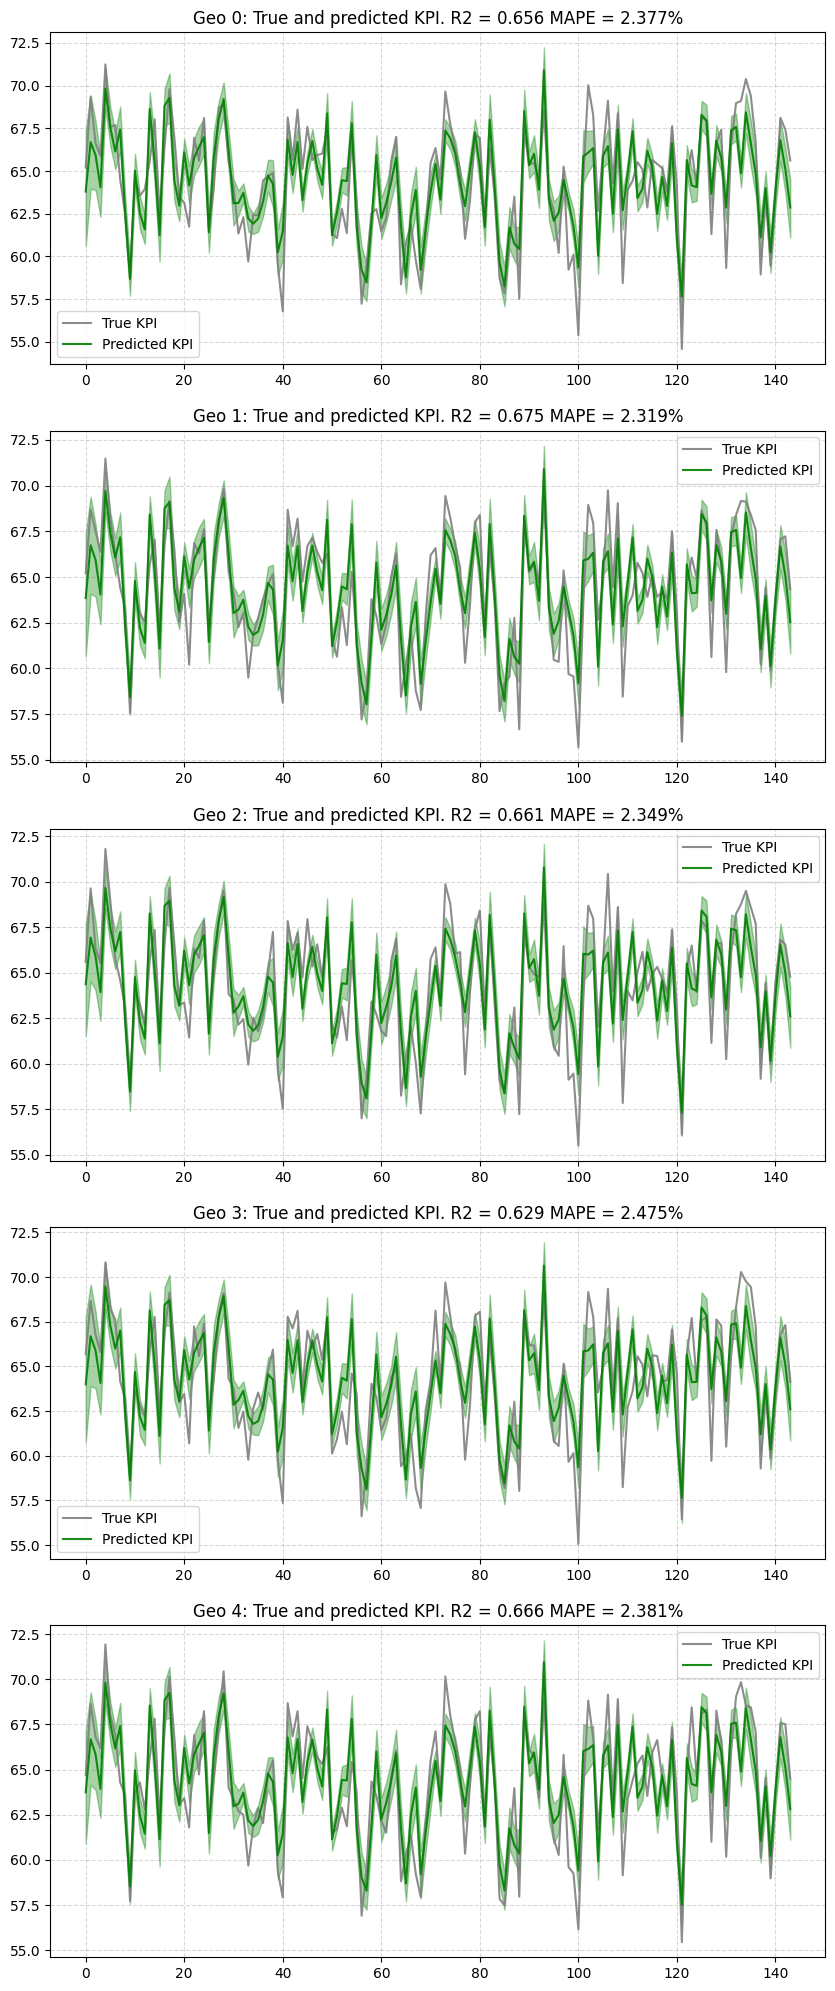

In [74]:
plot.plot_model_fit(media_mix_model=mmm, target_scaler=target_scaler)

If `target_scaler` used for `preprocessing.CustomScaler()` is given, the target would be unscaled. Bayesian R-squared and MAPE are shown in the chart.

### Predictive check

Users can get the prediction for the test data by:

In [75]:
prediction = mmm.predict(
    media=media_data_test,
    extra_features=extra_features_test,
    target_scaler=target_scaler
)

Returned prediction are distributions; if point estimates are desired, users can calculate those based on the given distribution. For example, if `data_size` of the test data is 20, `number_samples` is 1000 and `number_of_chains` is 2, `mmm.predict` returns 2000 sets of predictions with 20 data points. Users can compare the distributions with the true value of the test data and calculate the metrics such as mean and median.

In [76]:
prediction

Array([[[136.69247 , 113.90018 , 109.82762 , 112.29761 ,  97.033936],
        [149.5792  , 126.42637 , 117.55846 , 119.803024, 106.33498 ],
        [152.4302  , 127.74748 , 120.367905, 122.28753 , 107.62743 ],
        ...,
        [190.49828 , 165.47911 , 158.13808 , 160.46274 , 141.42361 ],
        [172.45956 , 142.00566 , 134.93414 , 138.02443 , 119.79023 ],
        [176.46591 , 146.83708 , 139.6207  , 142.5191  , 124.12859 ]],

       [[122.884   , 120.74202 , 150.94481 , 115.77866 , 127.83461 ],
        [134.11311 , 133.95415 , 159.09164 , 128.5417  , 138.43277 ],
        [136.43755 , 135.78003 , 163.5083  , 130.24971 , 141.27588 ],
        ...,
        [170.52075 , 169.59596 , 203.3708  , 163.1218  , 179.256   ],
        [147.41045 , 147.00749 , 178.81708 , 141.39273 , 154.59518 ],
        [152.05095 , 151.51753 , 183.66708 , 145.78645 , 159.44347 ]],

       [[172.48053 , 148.9529  , 170.28043 , 122.56267 , 134.6486  ],
        [183.698   , 160.04233 , 175.40028 , 133.92297 , 143

### Parameter estimation check

Users can get detail of the parameter estimation by:

In [77]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
            channel_coef_media[0,0]      1.13      1.00      1.07      0.00      2.47      1.11      2.84
            channel_coef_media[1,0]      1.01      0.54      0.94      0.16      1.81     49.42      1.04
            channel_coef_media[2,0]      1.45      0.59      1.40      0.51      2.36      5.02      1.13
           coef_extra_features[0,0]     -0.15      0.02     -0.15     -0.17     -0.13    201.00      1.02
           coef_extra_features[0,1]     -0.15      0.01     -0.15     -0.17     -0.12    450.68      1.01
           coef_extra_features[0,2]     -0.15      0.01     -0.15     -0.17     -0.13     55.34      1.03
           coef_extra_features[0,3]     -0.14      0.01     -0.14     -0.16     -0.11    476.15      1.01
           coef_extra_features[0,4]     -0.15      0.01     -0.15     -0.17     -0.13     46.23      1.03
           coef_extra_features[1,0]     -0.10

The above returns the mean, standard deviation, median and the credible interval for each parameter. The distribution charts are provided by:

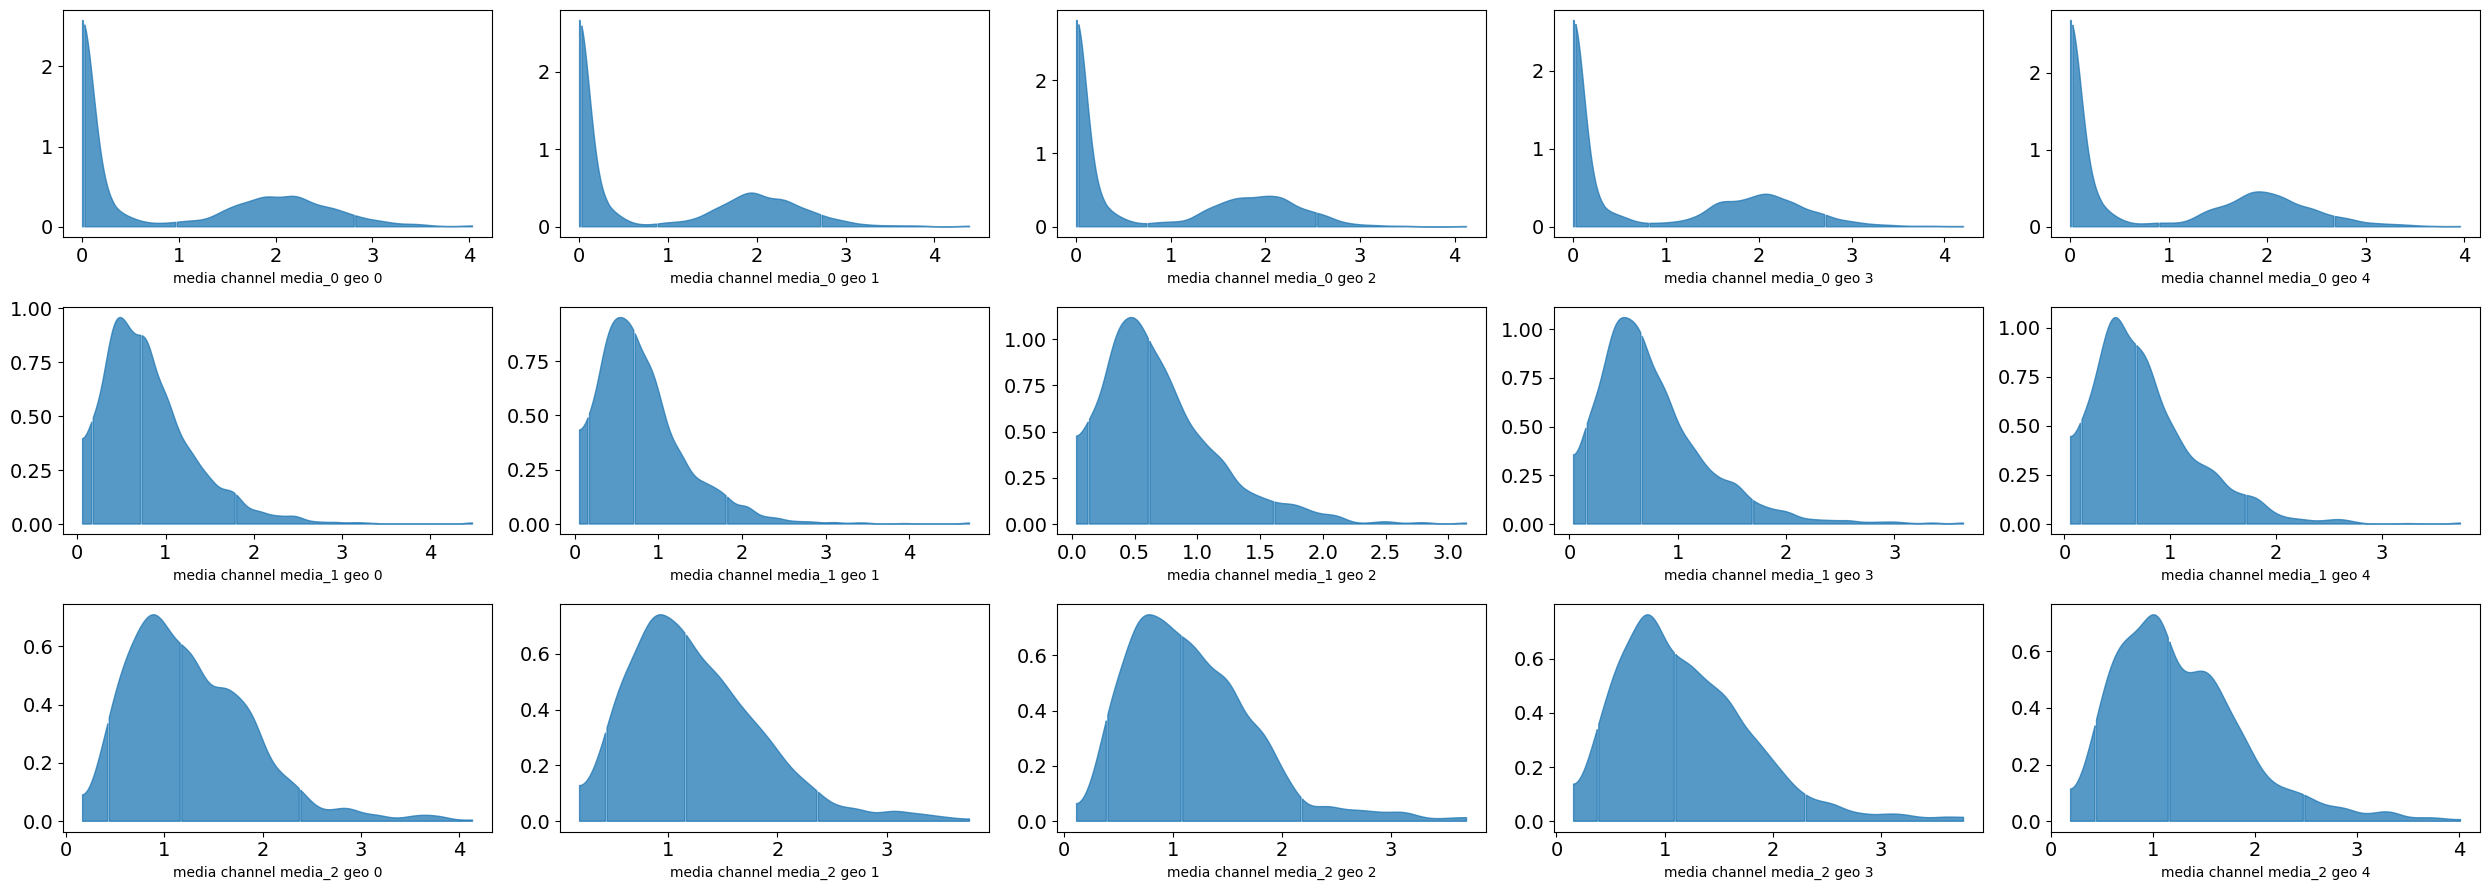

In [78]:
media_names = ['media_'+str(i) for i in range(media_data.shape[1])]
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=media_names)

`channel_names` specifies media names in each chart.

### Media insights

Response curves are provided as follows:

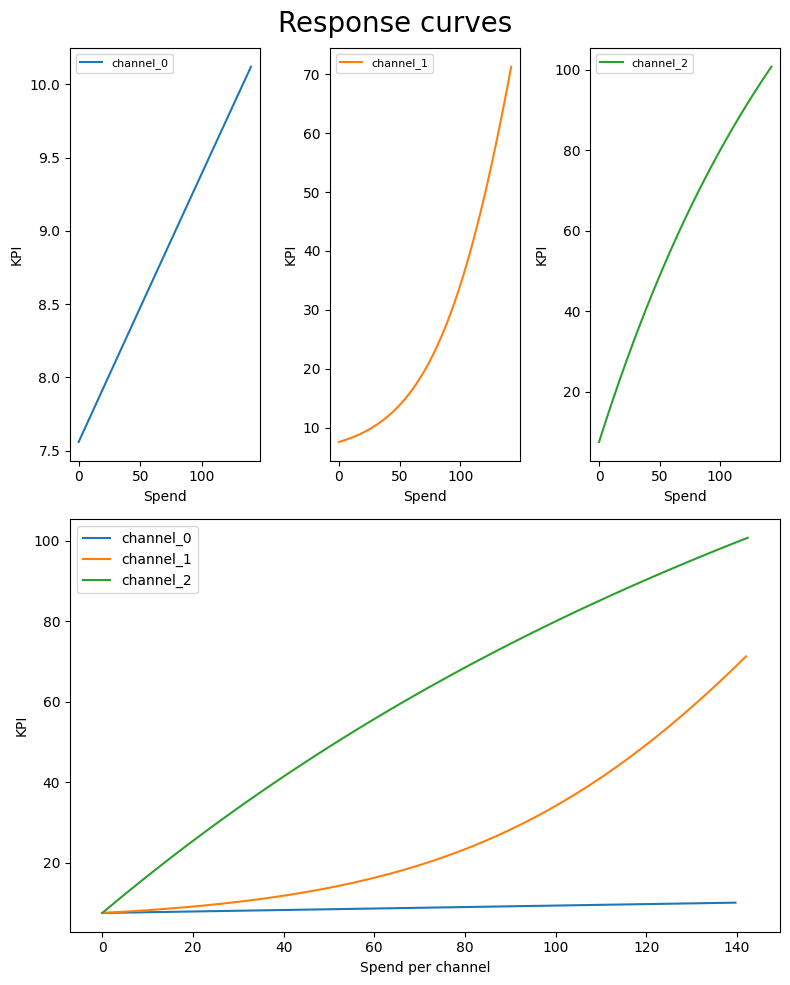

In [79]:
plot.plot_response_curves(media_mix_model=mmm, media_scaler=media_scaler, target_scaler=target_scaler)

If `media_scaler` and `target_scaler` used for `preprocessing.CustomScaler()` are given, both the media and target values would be unscaled.

To extract the media effectiveness and ROI estimation, users can do the following:

In [80]:
media_effect_hat, roi_hat = mmm.get_posterior_metrics()

`media_effect_hat` is the media effectiveness estimation and `roi_hat` is the ROI estimation. Then users can visualize the distribution of the estimation as follows:

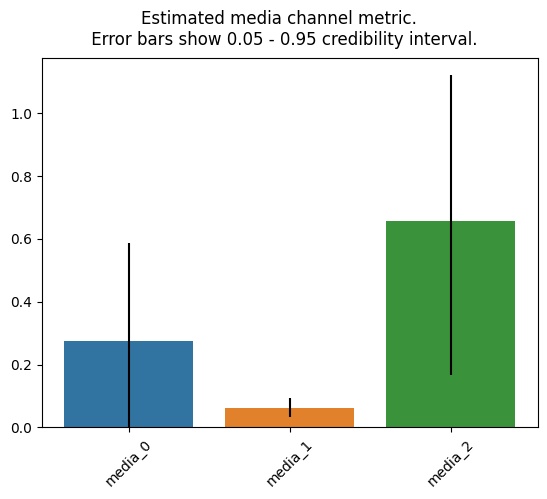

In [81]:
plot.plot_bars_media_metrics(metric=media_effect_hat, channel_names=media_names)

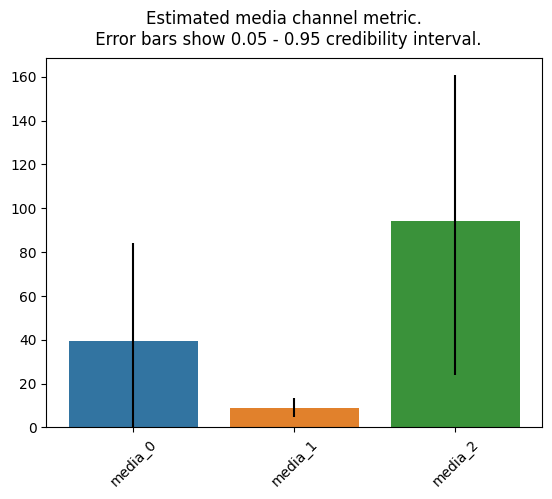

In [82]:
plot.plot_bars_media_metrics(metric=roi_hat, channel_names=media_names)

## Running the optimization

For optimization we will maximize the sales changing the media inputs such that the summed cost of the media is constant. We can also allow reasonable bounds on each media input (eg +- x%). We only optimise across channels and not over time. For running the optimization one needs the following main parameters:

- `n_time_periods`: The number of time periods you want to simulate (eg. Optimize for the next 10 weeks if you trained a model on weekly data).
- The model that was trained.
- The `budget` you want to allocate for the next `n_time_periods`.
- The extra features used for training for the following `n_time_periods`.
- Price per media unit per channel.
- `media_gap` refers to the media data gap between the end of training data and the start of the out of sample media given. Eg. if 100 weeks of data were used for training and prediction starts 2 months after training data finished we need to provide the 8 weeks missing between the training data and the prediction data so data transformations (adstock, carryover, ...) can take place correctly.

See below an example of optimization:

In [83]:
# Run media optimization.
budget = 40 # your budget here
prices = np.array([0.1, 0.11, 0.12])
extra_features_test = extra_features_scaler.transform(extra_features_test)
solution = optimize_media.find_optimal_budgets(
    n_time_periods=extra_features_test.shape[0],
    media_mix_model=mmm,
    budget=budget,
    extra_features=extra_features_test,
    prices=prices)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -98.55395013313174
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1


In [84]:
solution

( message: Positive directional derivative for linesearch
  success: False
   status: 8
      fun: -98.55395013313174
        x: [ 9.600e+01  9.600e+01  9.600e+01]
      nit: 5
      jac: [-4.906e-01 -5.234e-01 -2.934e-01]
     nfev: 7
     njev: 1,
 Array(-124.64962457, dtype=float64),
 Array([121.21212121, 121.21212121, 121.21212121], dtype=float64))

## Save and load the model

Users can save and load the model as follows:

In [87]:
utils.save_model(mmm, file_path='mmm.pkl')

Users can specify `file_path` to save the model. To load a saved MMM model:

In [88]:
utils.load_model(file_path='mmm.pkl')

LightweightMMM(model_name='hill_adstock')

## Questions

### What is `number_warmup` and `number_samples`?

The `number_warmup` and `number_samples` parameters are related to the Markov Chain Monte Carlo (MCMC) method used in the fitting process of the model.

`number_warmup`: This parameter specifies the number of warmup (or burn-in) iterations in the MCMC method. During these iterations, the sampler is allowed to converge towards the high-probability areas of the parameter space. These samples are then discarded because they do not accurately represent the desired distribution.

`number_samples`: This parameter specifies the number of samples to draw from the posterior distribution after the warmup phase. These samples are used to estimate the parameters of the model.

### Why the rule to look if `r_hat` values of all parameters are less than 1.1?

The `R-hat` value, also known as the potential scale reduction factor, is a measure used to assess the convergence of a Markov Chain Monte Carlo (MCMC) method. It compares the variance of different chains to the variance within each chain. If all chains have converged to the target distribution, these should be about the same, and `R-hat` should be close to 1.

The rule of thumb that `R-hat` values should be less than 1.1 is a heuristic for determining whether the chains have likely converged. If `R-hat` is significantly greater than 1, it suggests that the chains have not mixed well and may not have reached the target distribution, indicating that more iterations may be needed.

However, it's important to note that `R-hat` is just one diagnostic tool and should be used in conjunction with others (like inspecting trace plots or using effective sample size) to assess convergence.

### What are chains?

In the context of Markov Chain Monte Carlo (MCMC) methods, a "chain" refers to a sequence of samples drawn from a probability distribution. The goal of MCMC is to generate a chain of samples that, given enough time, will represent the target distribution we're interested in.

In practice, multiple chains are often run in parallel from different starting points. This helps to ensure that the sampling covers the entire distribution and doesn't get stuck in one part of the parameter space.

The term "chain" comes from the fact that each sample depends only on the previous one (like links in a chain), which is a property of Markov processes.

### How the MCMC works?

Markov Chain Monte Carlo (MCMC) is a class of algorithms used in computational statistics to sample from a probability distribution. It's particularly useful when direct sampling is difficult. Here's a simplified explanation of how it works:

1. **Initialization**: Choose an initial state for the Markov chain (i.e., an initial set of parameter values).

2. **Iteration**: For each iteration of the algorithm, propose a new state (a new set of parameter values). The way this new state is proposed can vary depending on the specific MCMC algorithm used (like Metropolis-Hastings, Gibbs sampling, or Hamiltonian Monte Carlo).

3. **Acceptance or Rejection**: Decide whether to accept the new state or reject it. This decision is based on the likelihood of the new state: if it's more likely than the current state given the data, it's always accepted. If it's less likely, it's accepted with a probability equal to the ratio of their likelihoods. This ensures that states are sampled with a frequency proportional to their likelihood, which is what we want when sampling from the posterior distribution in Bayesian inference.

4. **Convergence**: Repeat the iteration step many times. The Markov chain will eventually converge to the target distribution, meaning that the states it visits represent samples from the desired distribution.

5. **Burn-in and Thinning**: The first few samples (before the chain has converged) are usually discarded. This is known as the "burn-in" period. Additionally, to reduce autocorrelation between samples, we might only keep every nth sample. This is known as "thinning".

6. **Multiple Chains**: Often, several independent chains are run from different starting points. This helps to check that the chains are converging to the same distribution and not getting stuck in different parts of the parameter space.

Remember, this is a simplified explanation. The specifics can get quite complex, especially for more advanced MCMC methods like Hamiltonian Monte Carlo.